<a href="https://colab.research.google.com/github/lorenzkap/lecture/blob/main/lecture1_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Problem 1: The Multi-Armed Bandit (MAB)

With the basic concepts of Agent, Environment, State, Action, and Reward in mind, let's tackle our first problem: the **Multi-Armed Bandit (MAB)**. This is one of the simplest settings in RL, but it's fundamental for understanding a key challenge: the exploration-exploitation trade-off.

<br><br>
![Image](https://i.sstatic.net/04Ggq.jpg)
*Image credit: [Stats Stack Exchange - Multi-Armed Bandit Problem](https://stats.stackexchange.com/questions/326449/multi-armed-bandit-problem)*
<br><br>


Imagine walking into a casino and facing a row of slot machines (or "one-armed bandits"). Each machine has a lever (an "arm") you can pull. The critical detail is that each machine is programmed differently: pulling the arm of machine *i* yields a reward drawn from a specific, hidden probability distribution unique to that machine.

For instance:
*   Machine 1 might give rewards centered around $7 (e.g., $6.50, $7.20, $6.80).
*   Machine 5 might give rewards centered around $10.

The key is that the rewards are **stochastic** (random); you don't get the exact same amount every time, just values fluctuating around the machine's true hidden average.

Your goal is to maximize your winnings over a limited number of pulls.

### The Naive Approach vs. RL

You could try a brute-force method: pull each arm 100 times, record all rewards, calculate the average for each, and then stick to the best one. This would eventually work, but it's highly inefficient, wasting many pulls on suboptimal machines.

This is where RL provides a smarter approach. We want an agent that learns adaptively, figuring out which arms are best *while* minimizing pulls on bad ones.

### Setting up the Environment: The `Bandit` Class

First, we need to simulate this row of slot machines. Let's create a Python class to represent our MAB environment. We'll start by importing the necessary libraries and define the 'Bandit' class.

In [38]:
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
    """
    Represents a Multi-Armed Bandit environment.

    Args:
        true_means (list or np.array): A list containing the true mean reward
                                       for each arm.
    """
    def __init__(self, true_means):
        self.true_means = np.array(true_means)
        self.k = len(self.true_means) # Number of arms
        self.num_actions = self.k  # Alias for compatibility

        # Assume standard deviation of 1 for rewards from all arms
        self.std = np.ones(self.k)

        # Agent's estimates of the reward for each arm (initialized to 0)
        self.r_est = np.zeros(self.k)
        # Number of times each arm has been pulled (initialized to 0)
        self.n = np.zeros(self.k)

    def pull(self, action):
        """
        Simulates pulling an arm and returns a stochastic reward.

        Args:
            action (int): The index of the arm to pull (0 to k-1).

        Returns:
            float: A reward sampled from a Normal distribution centered
                   around the true mean for the chosen arm.
        """
        # Sample reward from Normal(mean=true_mean[action], std=1)
        reward = np.random.normal(self.true_means[action], self.std[action])
        return reward

    def update(self, action, reward):
        """
        Updates the agent's estimate for the pulled arm based on the reward received.

        Args:
            action (int): The index of the arm that was pulled.
            reward (float): The reward received from pulling the arm.
        """
        # Increment the pull count for the action
        self.n[action] += 1

        # Update the reward estimate using the incremental average formula:
        # new_estimate = old_estimate + step_size * (target - old_estimate)
        # Here, target = reward, step_size = 1/n[action]
        # self.r_est[action] = self.r_est[action] + (1 / self.n[action]) * (reward - self.r_est[action])

        # Simplified equivalent using +=
        self.r_est[action] += (reward - self.r_est[action]) / self.n[action]

    def reset(self):
        """Resets to state 0 (stateless, so no-op)."""
        return 0

    def step(self, action):
        """
        Takes an action, returns reward, state remains 0, never done.
        """
        reward = self.pull(action)
        return 0, reward, False

In [39]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [40]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [41]:
def get_action(Q, state, epsilon):
    """
    Selects an action using an epsilon-greedy policy based on Q-values.

    Args:
        Q (np.array): The Q-table (states x actions).
        state (int): The current state index.
        epsilon (float): The probability of choosing a random action (exploration).

    Returns:
        int: The index of the chosen action.
    """
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        action_idx = np.random.randint(0, Q.shape[1])
    else:
        # Exploit: choose the action with the highest Q-value for the current state
        action_idx = np.argmax(Q[state])
    return action_idx

#### Understanding the `Bandit` Class:

1.  **`__init__(self, true_means)`**:
    *   The constructor takes `true_means`, a list representing the hidden average payout of each arm. This is the "ground truth" the agent needs to discover.
    *   It stores these means and determines `k`, the number of arms.
    *   For simplicity, we assume the reward distribution for each arm is a Normal distribution with a standard deviation (`std`) of 1.
    *   Crucially, it initializes `r_est` (the agent's current *estimate* of each arm's reward) and `n` (the number of times each arm has been pulled) to zeros.
    *   **Note:** Technically, `r_est` and `n` represent the *agent's* knowledge. In a more complex setup, they might reside in a separate `Agent` class. For this simple MAB problem, we store them within the `Bandit` environment class for convenience.

2.  **`pull(self, action)`**:
    *   This method simulates pulling the specified `action` (arm index).
    *   It uses `np.random.normal` to draw a reward from a Normal distribution defined by the arm's `true_means` and `std`. This ensures the reward is stochastic.

3.  **`update(self, action, reward)`**:
    *   This method is called *after* the agent pulls an arm (`action`) and receives a `reward`.
    *   It first increments the count `n` for the arm that was just pulled.
    *   Then, it updates the reward estimate `r_est` for that arm using a common formula for calculating an incremental mean:
        *   `error = reward - self.r_est[action]` (How far off was our current estimate from the actual reward?)
        *   `step_size = 1 / self.n[action]` (How much weight do we give this new reward? Less weight as we get more samples.)
        *   `self.r_est[action] += step_size * error` (Nudge the old estimate towards the new reward, scaled by the step size.)
    *   This formula efficiently updates the average reward estimate without needing to store all past rewards. As `n` increases, the estimate becomes more stable.

### The Agent's Strategy: Exploration vs. Exploitation

Okay, we have our `Bandit` environment set up. It knows the true means (secretly), gives stochastic rewards, and helps track estimates. But the environment itself doesn't make decisions. We need an **agent strategy** (or policy) to decide which arm to pull at each step.

This immediately brings us to the **exploration-exploitation dilemma**:

*   **Explore:** Should the agent try out different arms, even those that currently seem mediocre based on `r_est`? It might get a low reward *now*, but it could discover a truly great arm that was initially underestimated.
*   **Exploite:** Should the agent just pull the arm that currently has the highest `r_est`? This maximizes the expected immediate reward based on current knowledge, but it risks missing out on the *actual* best arm if the initial estimates were wrong due to insufficient exploration.

A good strategy needs to balance these two. Explore enough to gather good information, but exploit that information effectively to maximize rewards.

### Epsilon-Greedy Strategy

One of the simplest and most popular strategies to balance this trade-off is **epsilon-greedy**.

The core idea is:
*   Most of the time (with probability 1 - ε), **exploit** by choosing the arm with the highest current estimated reward (`r_est`).
*   Some of the time (with probability ε), **explore** by choosing an arm completely at random.

Let's implement this strategy as a Python function.

In [42]:
def epsilon_greedy(bandit_instance, episodes=1000, epsilon=0.1):
    """
    Implements the epsilon-greedy strategy for a Multi-Armed Bandit problem.

    Args:
        bandit_instance (Bandit): An instance of the Bandit class.
        episodes (int): The total number of pulls (time steps) to run.
        epsilon (float): The probability of choosing an action randomly (exploration rate).

    Returns:
        tuple: A tuple containing:
            - np.array: The final estimated rewards for each arm (r_est).
            - np.array: A history of the reward received at each episode.
    """
    # Array to store the reward received at each episode
    rewards = np.zeros(episodes)

    # Main loop: iterate for the specified number of episodes
    for i in range(episodes):
        # Decide whether to explore or exploit
        if np.random.rand() < epsilon:
            # Explore: choose a random arm
            action = np.random.randint(0, bandit_instance.k)
        else:
            # Exploit: choose the arm with the highest current estimated reward
            action = np.argmax(bandit_instance.r_est)

        # Pull the chosen arm and get the reward
        reward = bandit_instance.pull(action)

        # Update the bandit's estimates based on the action and reward
        bandit_instance.update(action, reward)

        # Store the reward for this episode
        rewards[i] = reward

    # Return the final estimates and the history of rewards
    return bandit_instance.r_est, rewards

#### Understanding the `epsilon_greedy` Function:

1.  **Inputs:**
    *   `bandit_instance`: The `Bandit` environment we created.
    *   `episodes`: How many times the agent will pull an arm in total.
    *   `epsilon` (ε): The exploration probability (e.g., 0.1 means 10% chance of exploring).
2.  **Initialization:**
    *   Creates a `rewards` array to log the reward obtained at each step.
3.  **Main Loop (`for i in range(episodes):`)**:
    *   **Action Selection:**
        *   Generates a random float between 0 and 1 (`np.random.rand()`).
        *   If this float is less than `epsilon`, the agent **explores**: it picks a random arm index using `np.random.randint`.
        *   Otherwise (with probability 1-`epsilon`), the agent **exploits**: it uses `np.argmax(bandit_instance.r_est)` to find the index of the arm with the currently highest estimated reward.
    *   **Interaction:**
        *   Calls `bandit_instance.pull(action)` to get a `reward` from the environment based on the chosen `action`.
        *   Calls `bandit_instance.update(action, reward)` to update the estimates (`n` and `r_est`) for the chosen arm within the environment object.
    *   **Logging:** Stores the received `reward` in the `rewards` array.
4.  **Outputs:**
    *   Returns the final `bandit_instance.r_est` (the agent's learned estimates after all episodes).
    *   Returns the `rewards` array (the history of rewards obtained step-by-step).

This function encapsulates the entire agent's learning process using the epsilon-greedy strategy.

---

Now we have the `Bandit` environment and the `epsilon_greedy` learning algorithm. We're ready to set up an experiment, run the simulation, and see how well our agent learns!

### Running the Epsilon-Greedy Experiment

Let's put our `Bandit` environment and `epsilon_greedy` strategy into action.

First, since we use random numbers (for action selection in epsilon-greedy and for reward generation in `Bandit.pull`), it's good practice to set a random seed. This ensures that if we run the code again, we get the exact same sequence of "random" events, making our experiment reproducible. Next, define the parameters for our experiment: the total number of pulls (`episodes`) and the true underlying quality of each arm (`true_means`).

Then, we create an instance of our `Bandit` environment using these `true_means` and run the `epsilon_greedy` function.

In [43]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of episodes (pulls)
episodes = 1000

# Define the true mean reward for each of the 10 arms.
# These are the 'secrets' the agent needs to discover.
true_means = [0.1, -0.5, 1.5, 0.8, 1.1, -1.0, 0.3, 0.6, 1.7, 1.4]
# The best arm is index 8 with a true mean of 1.7
print(f"Number of arms: {len(true_means)}")
print(f"Maximum true mean reward: {max(true_means)}")

# Create a Bandit instance for the epsilon-greedy agent
bandit_eps = Bandit(true_means)

# Run the epsilon-greedy strategy
# Keep the default epsilon of 0.1 (10% exploration)
eps_final_r_est, rewards_eps = epsilon_greedy(bandit_eps, episodes, epsilon=0.1)

print(f"Ran {episodes} episodes for epsilon-greedy.")
# rewards_eps now holds the reward obtained at each of the 1000 steps.
# eps_final_r_est holds the agent's final estimate of each arm's value.

Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy.


#### Visualizing Performance: Cumulative Average Reward

Simply looking at the `rewards_eps` array (1000 individual rewards) isn't very informative about learning progress due to the inherent randomness. A better way to visualize learning is to plot the **cumulative average reward** over time. This shows the average reward obtained *up to* each step.

We calculate this as follows:

In [44]:
# Calculate cumulative average reward for epsilon-greedy
# np.cumsum(rewards_eps) calculates the cumulative sum at each step
# np.arange(episodes) + 1 creates an array [1, 2, ..., episodes]
avg_eps = np.cumsum(rewards_eps) / (np.arange(episodes) + 1)

Now, let's plot this average reward curve. We'll also add a line indicating the best possible average reward (the true mean of the best arm).

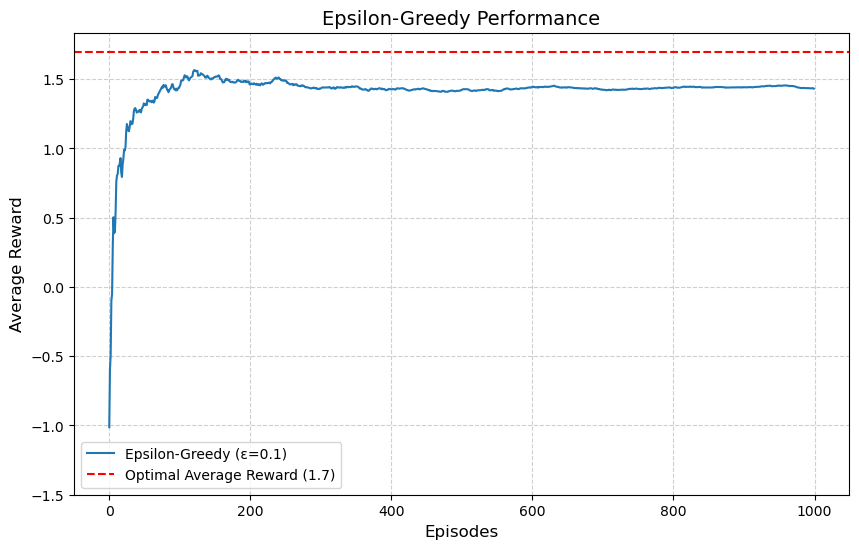

In [45]:
# --- Plotting Epsilon-Greedy Performance ---
plt.figure(figsize=(10, 6))

plt.plot(avg_eps, label='Epsilon-Greedy (ε=0.1)')

# A line for the best possible average reward
plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal Average Reward ({max(true_means)})')

plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Epsilon-Greedy Performance', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=min(true_means)-0.5)
plt.show()

Ran 1000 episodes of epsilon-greedy on the Bandit.
Final estimates: [ 0.234  0.127  1.499  0.987  1.248 -1.188 -0.408  0.732  1.017  1.371]


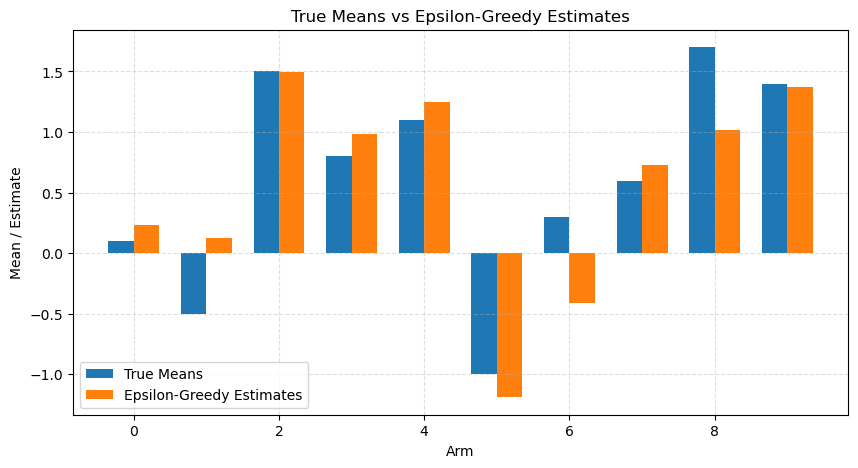

In [46]:
# Run epsilon-greedy on a fresh Bandit instance
bandit_eps_bar = Bandit(true_means)
eps_final_r_est_bar, rewards_eps_bar = epsilon_greedy(bandit_eps_bar, episodes=episodes, epsilon=0.1)

print(f"Ran {episodes} episodes of epsilon-greedy on the Bandit.")
print('Final estimates:', np.round(eps_final_r_est_bar, 3))

# Bar chart comparing learned estimates and true means
plt.figure(figsize=(10, 5))
indices = np.arange(len(true_means))
width = 0.35
plt.bar(indices - width/2, true_means, width, label='True Means')
plt.bar(indices + width/2, eps_final_r_est_bar, width, label='Epsilon-Greedy Estimates')
plt.xlabel('Arm')
plt.ylabel('Mean / Estimate')
plt.title('True Means vs Epsilon-Greedy Estimates')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### Interactive Exploration: Epsilon-Greedy Hyperparameters

Before diving into Q-Learning, let's experiment with the epsilon-greedy algorithm. Try different values of epsilon to see how exploration affects performance. You can modify the epsilon values below and re-run the cell to see the comparison.

100%|██████████| 4/4 [00:00<00:00, 501.43it/s]



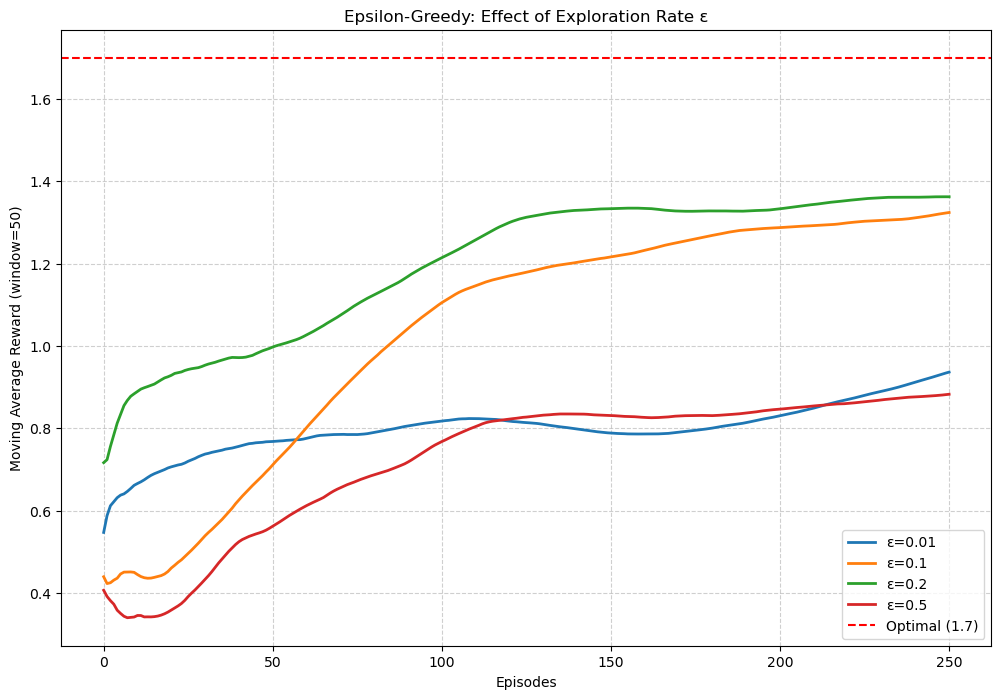

Final mean rewards for different ε:


100%|██████████| 4/4 [00:00<00:00, 572.95it/s]

ε=0.01: 1.5301
ε=0.1: 1.2657
ε=0.2: 1.1325
ε=0.5: 1.1707


In [47]:
# Interactive: Compare different epsilon values for epsilon-greedy
from tqdm import tqdm

# Define window size for moving average
window = 50

def moving_average(x, w):
    if len(x) < w:
        return np.convolve(x, np.ones(len(x))/len(x), mode='valid')
    return np.convolve(x, np.ones(w)/w, mode='valid')

epsilons_to_test = [0.01, 0.1, 0.2, 0.5]  # You can modify these values

# Use fewer episodes for faster testing
test_episodes = 300

results_eps = {}
for eps in tqdm(epsilons_to_test):
    bandit_test = Bandit(true_means)
    _, rewards_test = epsilon_greedy(bandit_test, episodes=test_episodes, epsilon=eps)
    avg_test = np.cumsum(rewards_test) / (np.arange(test_episodes) + 1)
    ma_test = moving_average(avg_test, window)
    results_eps[eps] = ma_test

# Plot comparison
plt.figure(figsize=(12, 8))
for eps, ma in results_eps.items():
    plt.plot(ma, label=f'ε={eps}', linewidth=2)

plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal ({max(true_means)})')
plt.xlabel('Episodes')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Epsilon-Greedy: Effect of Exploration Rate ε')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print final mean rewards
print("Final mean rewards for different ε:")
for eps in tqdm(epsilons_to_test):
    bandit_test = Bandit(true_means)
    _, rewards_test = epsilon_greedy(bandit_test, episodes=test_episodes, epsilon=eps)
    print(f"ε={eps}: {np.mean(rewards_test):.4f}")

### Q-learning explanation

Q-learning is a tabular temporal-difference method that directly learns an action-value function Q(s,a) by bootstrapping: each update moves the current estimate toward a one-step return (the TD target). In full MDPs the core update is:

$$Q(s,a) \leftarrow Q(s,a) + \alpha \bigl(r + \gamma \max_{a'} Q(s',a') - Q(s,a)\bigr)$$

Key points and intuition:
- The term $r + \gamma \max_{a'} Q(s',a')$ is the TD target: the observed immediate reward plus the best estimated future value.
- The difference (TD error) scales the correction: $\delta = r + \gamma \max_{a'} Q(s',a') - Q(s,a)$. We update Q(s,a) by a fraction $\alpha$ of this error.
- Q-learning is off-policy: the max operator uses the greedy (target) policy while the behaviour policy that collects data can be exploratory (e.g., $\epsilon$-greedy). This lets the agent explore while still learning the greedy value function.

Applying Q-learning to the Multi‑Armed Bandit:
- A bandit has no (meaningful) state: treat Q(a) as a per-action value. The update simplifies because there is no $s'$ with additional structure:

$$Q(a) \leftarrow Q(a) + \alpha \bigl(r - Q(a)\bigr)\quad\text{(stateless TD update)}$$

- Exploration: we use $\epsilon$-greedy to ensure the agent samples all arms (so estimates improve). In practice, it's helpful to *pull each arm once* before relying on argmax selection — this prevents ties or unpulled arms (with identical initial Q) from biasing choice. That's why the implementation first loops over i in range(k) and pulls each arm once.


In [48]:
def get_action(Q, state, epsilon):
    """
    Selects an action using an epsilon-greedy policy based on Q-values.

    Args:
        Q (np.array): The Q-table (states x actions).
        state (int): The current state index.
        epsilon (float): The probability of choosing a random action (exploration).

    Returns:
        int: The index of the chosen action.
    """
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        action_idx = np.random.randint(0, Q.shape[1])
    else:
        # Exploit: choose the action with the highest Q-value for the current state
        action_idx = np.argmax(Q[state])
    return action_idx

def q_learning(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    """
    Implements the Q-learning algorithm for a discrete state/action environment.

    Args:
        env: The environment with reset() and step(action) methods.
        episodes (int): The total number of episodes to train for.
        alpha (float): The learning rate.
        gamma (float): The discount factor.
        epsilon (float): The exploration rate for epsilon-greedy action selection.

    Returns:
        tuple: A tuple containing:
            - np.array: The learned Q-table.
            - list: A list of total rewards obtained in each episode.
    """
    num_states = 1  # For bandits, single state
    num_actions = env.num_actions

    # Initialize the Q-table with zeros
    Q = np.zeros((num_states, num_actions))

    # List to store total reward per episode
    rewards_per_episode = []

    # Main training loop over episodes
    for ep in range(episodes):
        state = env.reset()  # Start episode at the beginning state
        total_reward = 0
        
        # For bandits: each episode is one action (since done is always False)
        action_idx = get_action(Q, state, epsilon)
        next_state, reward, done = env.step(action_idx)
        total_reward += reward
        
        # Q-learning update
        target_q_value = reward + gamma * np.max(Q[next_state])
        Q[state, action_idx] += alpha * (target_q_value - Q[state, action_idx])
        
        # Episode finished, record total reward
        rewards_per_episode.append(total_reward)

    return Q, rewards_per_episode

#### Understanding the `q_learning` Function:

This function uses the exact same Q-learning algorithm as in Lecture 2 (MDPs), applied to the stateless Multi-Armed Bandit by treating it as a single-state MDP.

1.  **Inputs:**
    *   `env`: The environment instance with `reset()` and `step(action)` methods.
    *   `episodes`: Total number of episodes to train for.
    *   `alpha`: Learning rate for Q-updates.
    *   `gamma`: Discount factor (set to 0.0 for bandits).
    *   `epsilon`: Exploration probability for epsilon-greedy.

2.  **Initialization:**
    *   Sets `num_states = 1` (single state for bandits), `num_actions = env.num_actions`.
    *   Initializes Q-table as `np.zeros((1, num_actions))`.

3.  **Main Training Loop:**
    *   For each episode: reset environment, run episode with epsilon-greedy actions and Q-learning updates.
    *   Uses the same TD update as Lecture 2: `Q[state, action] += alpha * (target_q_value - Q[state, action])`

4.  **Outputs:**
    *   Returns `Q` (the Q-table) and `rewards_per_episode` (list of total rewards per episode).

This ensures the Q-learning implementation is identical between lectures, avoiding duplication.


### Interactive Exploration: Q-Learning Hyperparameters

Now let's experiment with Q-Learning hyperparameters. You can modify the learning rate (alpha), discount factor (gamma), and exploration rate (epsilon) below to see how they affect performance.

100%|██████████| 3/3 [00:00<00:00, 258.04it/s]



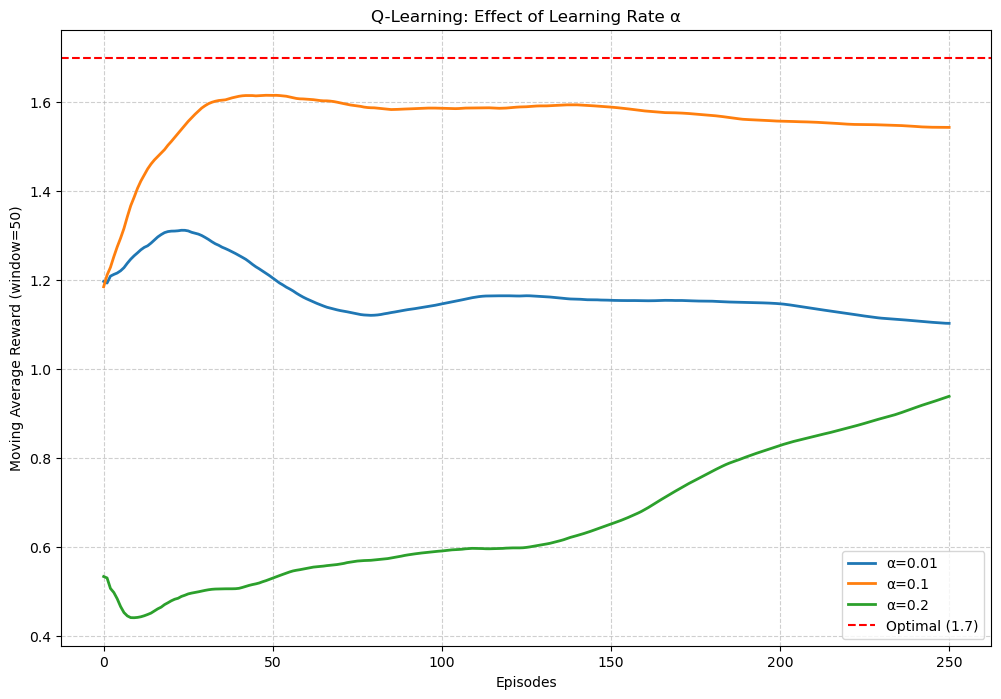

100%|██████████| 3/3 [00:00<00:00, 273.45it/s]



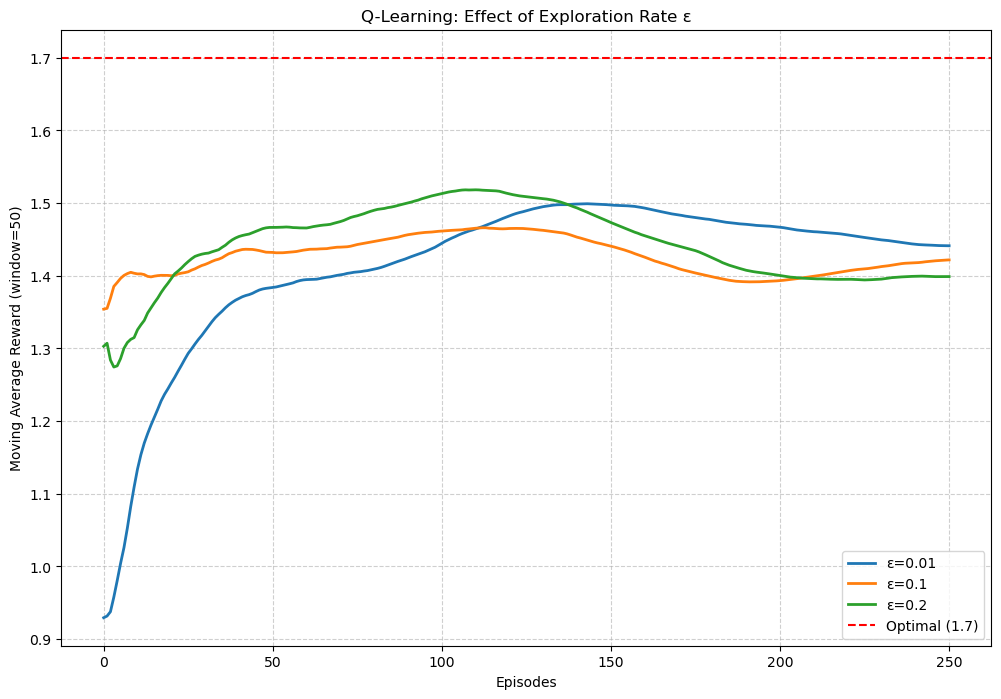

In [49]:
# Interactive: Compare different Q-Learning hyperparameters
from tqdm import tqdm

alphas_to_test = [0.01, 0.1, 0.2]  # Learning rates - try 0.05, 0.5
gammas_to_test = [0.0, 0.5, 0.9]   # Discount factors - try 0.1, 0.99
epsilons_to_test = [0.01, 0.1, 0.2] # Exploration rates - try 0.05, 0.5

# Use fewer episodes for faster testing
test_episodes = 300

# Test different alphas with fixed gamma=0.0, epsilon=0.1
results_alpha = {}
for alpha in tqdm(alphas_to_test):
    bandit_test = Bandit(true_means)
    Q_test, rewards_test = q_learning(bandit_test, episodes=test_episodes, alpha=alpha, gamma=0.0, epsilon=0.1)
    avg_test = np.cumsum(rewards_test) / (np.arange(test_episodes) + 1)
    ma_test = moving_average(avg_test, window)
    results_alpha[alpha] = ma_test

plt.figure(figsize=(12, 8))
for alpha, ma in results_alpha.items():
    plt.plot(ma, label=f'α={alpha}', linewidth=2)

plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal ({max(true_means)})')
plt.xlabel('Episodes')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Q-Learning: Effect of Learning Rate α')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Test different epsilons with fixed alpha=0.1, gamma=0.0
results_eps_ql = {}
for eps in tqdm(epsilons_to_test):
    bandit_test = Bandit(true_means)
    Q_test, rewards_test = q_learning(bandit_test, episodes=test_episodes, alpha=0.1, gamma=0.0, epsilon=eps)
    avg_test = np.cumsum(rewards_test) / (np.arange(test_episodes) + 1)
    ma_test = moving_average(avg_test, window)
    results_eps_ql[eps] = ma_test

plt.figure(figsize=(12, 8))
for eps, ma in results_eps_ql.items():
    plt.plot(ma, label=f'ε={eps}', linewidth=2)

plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal ({max(true_means)})')
plt.xlabel('Episodes')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Q-Learning: Effect of Exploration Rate ε')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

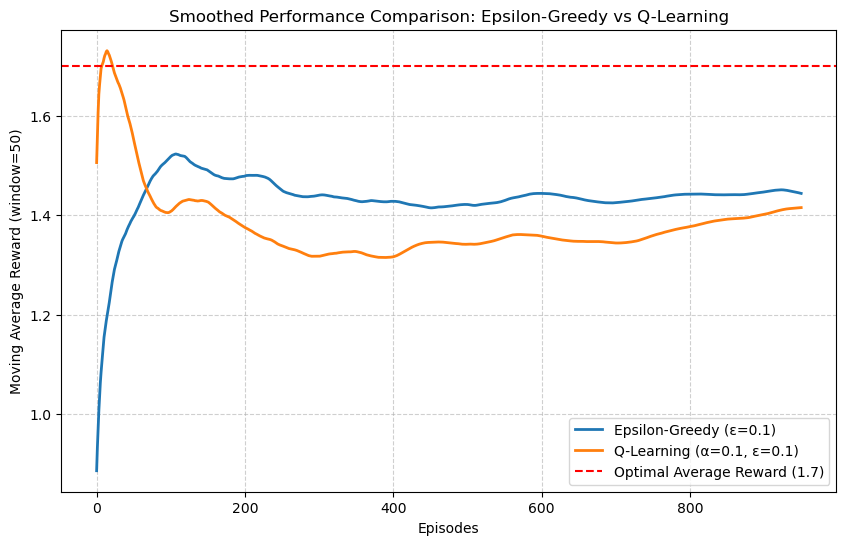

Epsilon-Greedy mean reward: 1.4320
Q-Learning mean reward: 1.4141


In [50]:
# Compare learning curves: epsilon-greedy (sample-average) vs Q-learning (fixed-alpha)
# First, run Q-learning to get rewards_q
bandit_q = Bandit(true_means)
Q_table, rewards_q = q_learning(bandit_q, episodes=episodes, alpha=0.1, gamma=0.0, epsilon=0.1)

window = 50

def moving_average(x, w):
    if len(x) < w:
        return np.convolve(x, np.ones(len(x))/len(x), mode='valid')
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Cumulative average rewards
avg_eps = np.cumsum(rewards_eps) / (np.arange(episodes) + 1)
avg_q = np.cumsum(rewards_q) / (np.arange(episodes) + 1)

# Moving averages for smoother curves
ma_eps = moving_average(avg_eps, window)
ma_q = moving_average(avg_q, window)

# Plot with moving averages
plt.figure(figsize=(10, 6))
plt.plot(ma_eps, label='Epsilon-Greedy (ε=0.1)', linewidth=2)
plt.plot(ma_q, label='Q-Learning (α=0.1, ε=0.1)', linewidth=2)
plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal Average Reward ({max(true_means)})')
plt.xlabel('Episodes')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Smoothed Performance Comparison: Epsilon-Greedy vs Q-Learning')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print mean rewards
print(f"Epsilon-Greedy mean reward: {np.mean(rewards_eps):.4f}")
print(f"Q-Learning mean reward: {np.mean(rewards_q):.4f}")

Ran 1000 episodes of Q-learning on the Bandit (with initial pulls).
Final Q (estimates): [-0.211 -0.237  1.238  0.487  0.659 -0.755  0.247  0.209  0.634  0.554]


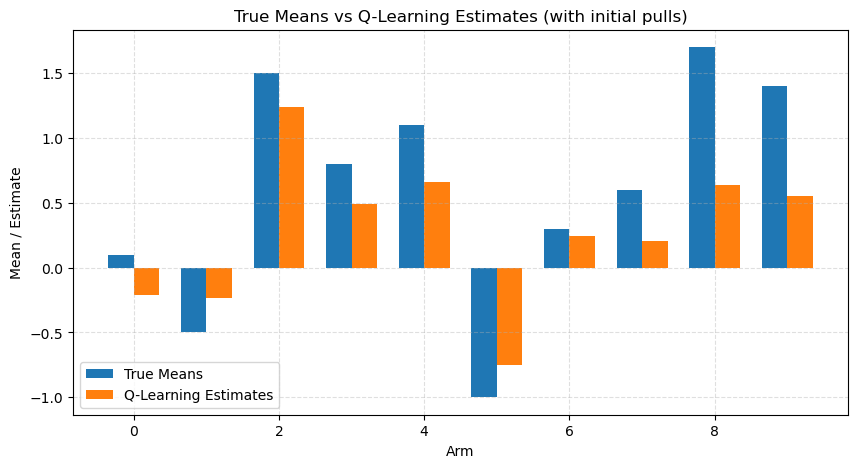

In [51]:
# Run Q-learning on a fresh Bandit instance
bandit_q = Bandit(true_means)
Q_table, rewards_q = q_learning(bandit_q, episodes=episodes, alpha=0.1, gamma=0.0, epsilon=0.1)
q_final_r_est = Q_table[0]
q_final_r_est = Q_table[0]

print(f"Ran {episodes} episodes of Q-learning on the Bandit (with initial pulls).")
print('Final Q (estimates):', np.round(q_final_r_est, 3))

# Bar chart comparing learned estimates and true means
plt.figure(figsize=(10, 5))
indices = np.arange(len(true_means))
width = 0.35
plt.bar(indices - width/2, true_means, width, label='True Means')
plt.bar(indices + width/2, q_final_r_est, width, label='Q-Learning Estimates')
plt.xlabel('Arm')
plt.ylabel('Mean / Estimate')
plt.title('True Means vs Q-Learning Estimates (with initial pulls)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()